<a href="https://colab.research.google.com/github/fahim1703061/Hyperspectral-Image-Processing/blob/main/Copy_V2_of_Hyperspectral_Analysis(Visualization)_%2B_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/aditis1204/Hypespectral_Visualization_Classification

### Downloading Indian pines hyperspecral dataset:

In [1]:
!wget "http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat"


!wget "http://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat"
!wget "http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat"

--2023-02-26 21:51:44--  http://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat [following]
--2023-02-26 21:51:44--  https://www.ehu.eus/ccwintco/uploads/6/67/Indian_pines_corrected.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5953527 (5.7M)
Saving to: ‘Indian_pines_corrected.mat’

Indian_pines_correc 100%[===================>]   5.68M  2.39MB/s    in 2.4s    

2023-02-26 21:51:47 (2.39 MB/s) - ‘Indian_pines_corrected.mat’ saved [5953527/5953527]

URL transformed to HTTPS due to an HSTS policy
--2023-02-26 21:51:47--  https://www.ehu.eus/ccwintco/uploads/c/c4/Indian_pines_gt.mat
Resolving www.ehu.eus (www.ehu.e

### Useful imports

In [2]:
import keras
from keras.layers import Conv2D, Conv3D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score

from operator import truediv

from plotly.offline import init_notebook_mode

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import os

In [ ]:
!ls


Indian_pines_corrected.mat    Indian_pines_corrected.mat.3  sample_data
Indian_pines_corrected.mat.1  Indian_pines_gt.mat
Indian_pines_corrected.mat.2  Indian_pines_gt.mat.1


In [3]:

## Importing Library.
from scipy.io import loadmat

In [4]:

dataset = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
ground_truth = loadmat('Indian_pines_gt.mat')['indian_pines_gt']

In [ ]:

#The dimensions of the data.
print(f'Dataset: {dataset.shape}\nGround Truth: {ground_truth.shape}')
#print(f'Dataset1: {dataset1.shape}\nGround Truth1: {ground_truth1.shape}')

Dataset: (145, 145, 200)
Ground Truth: (145, 145)


Data visualization:

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

def plot_band(dataset):
    plt.figure(figsize=(8, 6))
    band_no = np.random.randint(dataset.shape[2])
    plt.imshow(dataset[:,:, band_no], cmap='viridis')
    plt.imshow(dataset[:,:, band_no], cmap='nipy_spectral')

    plt.title(f'Band-{band_no}', fontsize=14)
    plt.axis('off')
    plt.colorbar()
    plt.show()

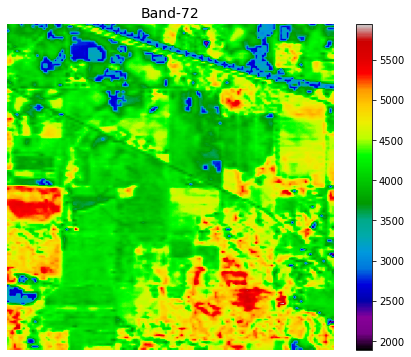

In [ ]:
plot_band(dataset)

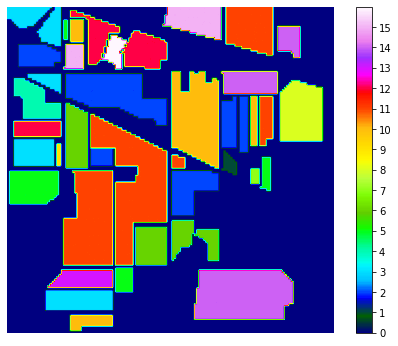

In [ ]:

plt.figure(figsize=(8, 6))
plt.imshow(ground_truth, cmap='gist_ncar')
# plt.imshow(ground_truth, cmap='nipy_spectral')
plt.axis('off')
plt.colorbar(ticks= range(0,16))
plt.show()

### Extracting Band Information:

In [5]:
from tqdm import tqdm
import pandas as pd
def extract_pixels(dataset, ground_truth):
    df = pd.DataFrame()
    for i in tqdm(range(dataset.shape[2])):
        df = pd.concat([df, pd.DataFrame(dataset[:, :, i].ravel())], axis=1)
    df = pd.concat([df, pd.DataFrame(ground_truth.ravel())], axis=1)
    df.columns = [f'band-{i}' for i in range(1, 1+dataset.shape[2])]+['class']
    return df

In [6]:
df = extract_pixels(dataset, ground_truth)
df.head()

100%|██████████| 200/200 [00:00<00:00, 301.18it/s]


,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,...,band-192,band-193,band-194,band-195,band-196,band-197,band-198,band-199,band-200,class
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,...,1094,1090,1112,1090,1062,1069,1057,1020,1020,3
1,2580,4266,4502,4426,4853,5249,5352,5353,5347,5065,...,1108,1104,1117,1091,1079,1085,1064,1029,1020,3
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,...,1111,1114,1114,1100,1065,1092,1061,1030,1016,3
3,2749,4258,4603,4493,4958,5234,5417,5355,5349,5096,...,1122,1108,1109,1109,1071,1088,1060,1030,1006,3
4,2746,4018,4675,4417,4886,5117,5215,5096,5098,4834,...,1110,1107,1112,1094,1072,1087,1052,1034,1019,3


In [19]:
df

,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,...,band-192,band-193,band-194,band-195,band-196,band-197,band-198,band-199,band-200,class
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,...,1094,1090,1112,1090,1062,1069,1057,1020,1020,3
1,2580,4266,4502,4426,4853,5249,5352,5353,5347,5065,...,1108,1104,1117,1091,1079,1085,1064,1029,1020,3
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,...,1111,1114,1114,1100,1065,1092,1061,1030,1016,3
3,2749,4258,4603,4493,4958,5234,5417,5355,5349,5096,...,1122,1108,1109,1109,1071,1088,1060,1030,1006,3
4,2746,4018,4675,4417,4886,5117,5215,5096,5098,4834,...,1110,1107,1112,1094,1072,1087,1052,1034,1019,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21020,2561,3987,4011,4023,4201,4377,4418,4248,4180,3838,...,1013,1012,1018,1015,1011,1001,1000,1009,1008,0
21021,2726,4104,4024,3880,4210,4377,4413,4174,4229,3900,...,1012,1014,1012,1024,998,1010,1006,1000,1000,0
21022,3153,3864,4282,3889,4310,4372,4375,4208,4096,3878,...,1016,1015,1016,1021,1008,1019,1003,1008,1000,0
21023,3155,4104,4106,4027,4139,4318,4413,4174,4140,3933,...,1005,1011,1008,1012,1014,1007,1011,1005,1003,0


In [21]:
print(df["class"].unique())

[ 3  0 15 11 12  5 10 14 16  2  4  8  6  9  1  7 13]


In [20]:
df.to_csv('Dataset.csv', index=False)

In [ ]:
def plot_signature(df):
    plt.figure(figsize=(12, 6))
    pixel_no = np.random.randint(df.shape[0])
    plt.plot(range(1, 201), df.iloc[pixel_no, :-1].values.tolist(), 'b--', label= f'Class - {df.iloc[pixel_no, -1]}')
    plt.legend()
    plt.title(f'Pixel({pixel_no}) signature', fontsize=14)
    plt.xlabel('Band Number', fontsize=14)
    plt.ylabel('Pixel Intensity', fontsize=14)
    plt.show()

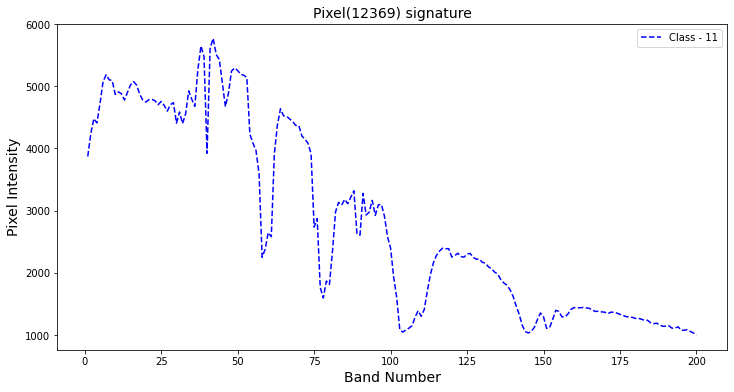

In [ ]:
plot_signature(df)

In [ ]:
ls

Dataset.csv                   Indian_pines_corrected.mat.3
Indian_pines_corrected.mat    Indian_pines_gt.mat
Indian_pines_corrected.mat.1  Indian_pines_gt.mat.1
Indian_pines_corrected.mat.2  sample_data/


In [ ]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
df.sample(6)

,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,...,band-192,band-193,band-194,band-195,band-196,band-197,band-198,band-199,band-200,class
14770,2585,3984,4119,3960,4277,4495,4528,4357,4301,4054,...,1022,1033,1032,1017,1015,1019,1022,1005,1014,0
4745,3170,3997,4046,3882,4151,4317,4322,4179,4048,3835,...,1019,1018,1019,1008,1005,1005,1007,1006,1000,14
15085,2588,3971,3852,3815,4095,4313,4281,4122,4041,3893,...,1026,1028,1026,999,1015,1002,1007,997,1014,0
1167,2743,4388,4510,4488,4888,5342,5421,5415,5426,5108,...,1105,1107,1122,1100,1073,1082,1064,1039,1015,3
8642,2595,4119,4225,4406,4821,5022,5177,5056,5010,4819,...,1085,1089,1096,1082,1059,1072,1050,1011,1009,10
18650,2560,3977,3931,3881,4146,4219,4413,4135,4048,3747,...,1020,1008,1008,998,1010,1006,1003,1000,1014,14


In [ ]:
print(f'Shape of the data: {df.shape}')

Shape of the data: (21025, 201)


### Band Information visualization:

In [ ]:
print(f"Unique Class Labels: {df.loc[:, 'class'].unique()}")

Unique Class Labels: [ 3  0 15 11 12  5 10 14 16  2  4  8  6  9  1  7 13]


In [ ]:
df.loc[:, 'class'].value_counts()

0     10776
11     2455
2      1428
14     1265
10      972
3       830
6       730
12      593
5       483
8       478
15      386
4       237
13      205
16       93
1        46
7        28
9        20
Name: class, dtype: int64

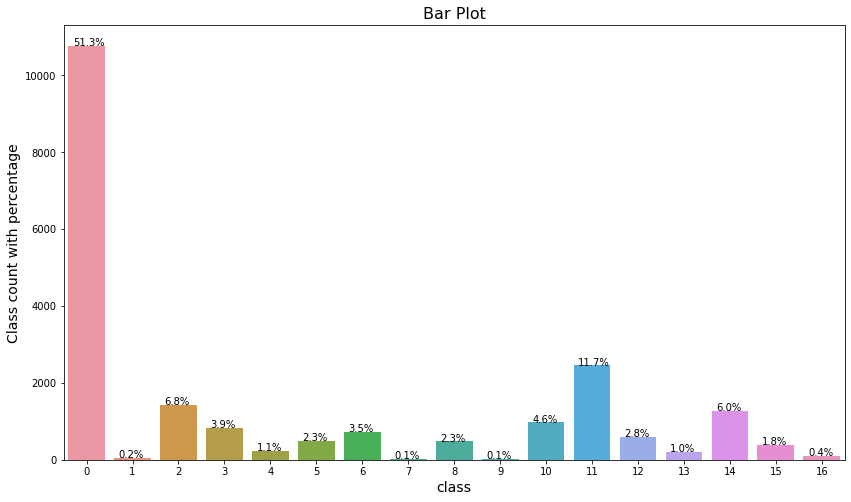

In [ ]:

plt.figure(figsize=(14, 8))

ax = sns.countplot(x='class', data=df[['class']])

for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/df.shape[0]), (p.get_x()+0.1, p.get_height()+5))
#ax.yaxis.set_major_locator(ticker.LinearLocator(11))

plt.ylabel('Class count with percentage', fontsize=14)

plt.xlabel('class', fontsize=14)

plt.title('Bar Plot', fontsize=16)

plt.show()

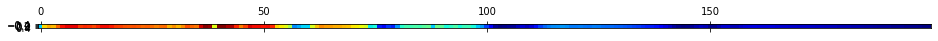

In [ ]:
# Visualizing the pixel
plt.matshow(df.iloc[1, :-1].values.reshape(1,200), cmap='jet');

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_pixel(pixel, n):
    ax = plt.gca()
    im = ax.imshow(pixel.reshape(10, 20), cmap = 'jet')
    plt.title(f'pixel - {n}')
    plt.axis('off')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()

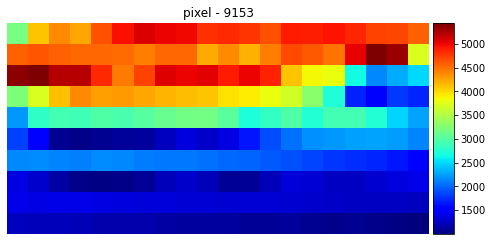

In [ ]:
plt.figure(figsize=(8, 4))

rand_n = np.random.randint(df.shape[0])

plot_pixel(df.iloc[rand_n, :-1].values, rand_n)

Enter the band Number(1-200) :76


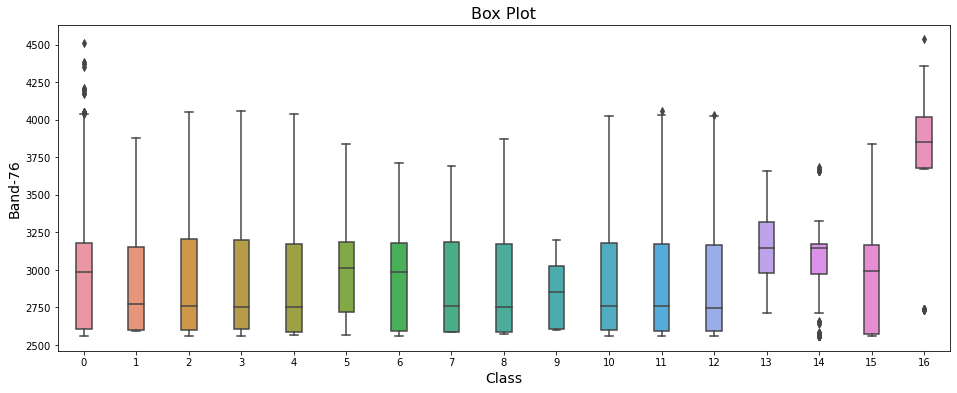

In [ ]:
plt.figure(figsize=(16, 6))
n = int(input('Enter the band Number(1-200) :'))
sns.boxplot( x=df["class"], y=df["band-1"], width=0.3);
plt.title('Box Plot', fontsize= 16)
plt.xlabel('Class', fontsize= 14)
plt.ylabel(f'Band-{n}', fontsize= 14)
plt.show()

In [ ]:
print(f"Details of Band - {n}: \n\n{df['band-'+str(n)].describe()}")

Details of Band - 76: 

count    21025.000000
mean      2911.013127
std        226.445691
min       1542.000000
25%       2770.000000
50%       2909.000000
75%       3069.000000
max       3920.000000
Name: band-76, dtype: float64


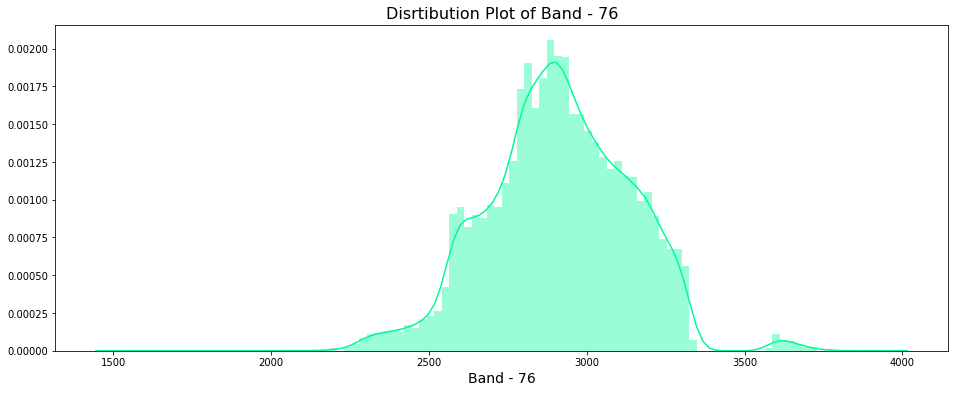

In [ ]:

plt.figure(figsize=(16, 6))
sns.distplot(df['band-'+str(n)], color='mediumSpringGreen', bins=100, hist_kws={'alpha': 0.4});
plt.xlabel('Band - '+str(n), fontsize=14)
plt.title('Disrtibution Plot of Band - '+str(n), fontsize=16)
plt.show()

### Implemetation of Dimensionality reduction using truncated SVD

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
# !pip install seaborn
import seaborn as sns
from sklearn.svm import SVC
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import train_test_split

In [ ]:
df = pd.read_csv('Dataset.csv')
df

,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,band-11,band-12,band-13,band-14,band-15,band-16,band-17,band-18,band-19,band-20,band-21,band-22,band-23,band-24,band-25,band-26,band-27,band-28,band-29,band-30,band-31,band-32,band-33,band-34,band-35,band-36,band-37,band-38,band-39,band-40,...,band-162,band-163,band-164,band-165,band-166,band-167,band-168,band-169,band-170,band-171,band-172,band-173,band-174,band-175,band-176,band-177,band-178,band-179,band-180,band-181,band-182,band-183,band-184,band-185,band-186,band-187,band-188,band-189,band-190,band-191,band-192,band-193,band-194,band-195,band-196,band-197,band-198,band-199,band-200,class
0,3172,4142,4506,4279,4782,5048,5213,5106,5053,4750,4816,4769,4610,4805,4828,4861,4767,4624,4549,4463,4462,4446,4445,4336,4381,4319,4207,4305,4311,3991,4168,3942,4061,4362,4318,4252,4869,5284,5055,3591,...,1396,1381,1396,1381,1353,1346,1341,1332,1324,1310,1318,1330,1310,1292,1280,1275,1266,1264,1233,1241,1232,1215,1215,1187,1168,1171,1150,1134,1123,1135,1094,1090,1112,1090,1062,1069,1057,1020,1020,3
1,2580,4266,4502,4426,4853,5249,5352,5353,5347,5065,5141,5100,4994,5172,5290,5289,5217,5053,5033,4939,4931,4941,4902,4824,4859,4805,4698,4794,4806,4452,4628,4433,4643,4967,4853,4760,5449,5768,5684,3987,...,1421,1415,1428,1415,1379,1370,1360,1353,1352,1336,1346,1351,1330,1315,1305,1292,1282,1286,1259,1259,1250,1229,1232,1195,1177,1184,1153,1137,1138,1137,1108,1104,1117,1091,1079,1085,1064,1029,1020,3
2,3687,4266,4421,4498,5019,5293,5438,5427,5383,5132,5227,5172,5097,5313,5411,5412,5341,5191,5140,5069,5110,5119,5046,4981,5023,4987,4862,4965,4992,4595,4756,4529,4801,5077,4983,4868,5515,5972,5913,4027,...,1446,1440,1443,1425,1390,1379,1376,1363,1355,1347,1361,1356,1341,1330,1321,1304,1290,1289,1263,1269,1261,1245,1241,1214,1185,1188,1156,1147,1149,1144,1111,1114,1114,1100,1065,1092,1061,1030,1016,3
3,2749,4258,4603,4493,4958,5234,5417,5355,5349,5096,5147,5078,5040,5237,5321,5344,5255,5121,5035,4956,4994,4980,4905,4857,4900,4831,4720,4848,4847,4484,4613,4402,4674,4966,4848,4776,5473,5894,5789,4086,...,1432,1427,1426,1416,1386,1374,1375,1359,1343,1343,1354,1351,1333,1329,1313,1296,1280,1281,1251,1255,1253,1238,1223,1207,1188,1188,1154,1143,1144,1146,1122,1108,1109,1109,1071,1088,1060,1030,1006,3
4,2746,4018,4675,4417,4886,5117,5215,5096,5098,4834,4853,4857,4734,4879,4976,4958,4885,4754,4647,4532,4586,4591,4492,4453,4497,4398,4297,4408,4401,4102,4227,4075,4264,4529,4490,4438,5001,5378,5321,3779,...,1401,1397,1395,1390,1368,1349,1354,1340,1330,1324,1336,1332,1320,1307,1287,1283,1267,1265,1239,1240,1239,1229,1212,1202,1178,1178,1143,1135,1138,1135,1110,1107,1112,1094,1072,1087,1052,1034,1019,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21020,2561,3987,4011,4023,4201,4377,4418,4248,4180,3838,3762,3696,3594,3750,3806,3764,3655,2611,3199,3036,2978,2837,2758,2650,2617,2494,2397,2366,2313,2198,2464,2261,2490,3124,3643,4349,5748,6973,7199,5067,...,1082,1079,1077,1086,1071,1084,1079,1076,1082,1077,1082,1078,1077,1068,1070,1053,1063,1055,1052,1047,1042,1043,1031,1025,1034,1029,1026,1025,1018,1021,1013,1012,1018,1015,1011,1001,1000,1009,1008,0
21021,2726,4104,4024,3880,4210,4377,4413,4174,4229,3900,3786,3696,3623,3726,3758,3725,3614,2584,3174,3042,2958,2837,2769,2626,2617,2484,2387,2362,2322,2199,2463,2188,2444,3077,2808,4239,5706,6965,7227,5108,...,1086,1076,1086,1081,1069,1086,1078,1081,1078,1075,1084,1087,1082,1071,1064,1059,1063,1051,1049,1042,1042,1043,1031,1029,1029,1026,1021,1026,1021,1023,1012,1014,1012,1024,998,1010,1006,1000,1000,0
21022,3153,3864,4282,3889,4310,4372,4375,4208,4096,3878,3890,3683,3594,3714,3724,3700,2809,2564,3177,3031,2925,2837,2719,2605,2603,2476,2373,2335,2308,2198,2449,2164,2443,

In [7]:
X = df.iloc[:, :-1].values

y = df.iloc[:, -1].values



In [8]:
X.shape, y.shape
# print(y[100])

((21025, 200), (21025,))

In [24]:
#kpca = KernelPCA(n_components = 50, kernel='poly', eigen_solver='arpack')
kpca = PCA(n_components=200, whiten=True) 
#pca = PCA(n_components=numComponents, svd_solver='arpack')
principalComponents = kpca.fit_transform(X)

principalComponents.shape

(21025, 200)

In [15]:


X_train, X_test, y_train, y_test, indices_train, indices_test  = train_test_split(principalComponents, y,  range(X.shape[0]), 
                                                                                  test_size = 0.15, random_state = 11)

NameError: ignored

In [26]:
X_train.shape, X_test.shape

((17871, 200), (3154, 200))

In [27]:
y_train.shape, y_test.shape

((17871,), (3154,))

In [ ]:

svm = SVC(kernel='rbf', degree = 11, gamma='scale', cache_size=1024*7)
svm.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=7168, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=11, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
y_pred = svm.predict(X_test)

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(f'Accuracy: {accuracy_score(y_test, y_pred)*100}%')


Accuracy: 74.76220672162334%


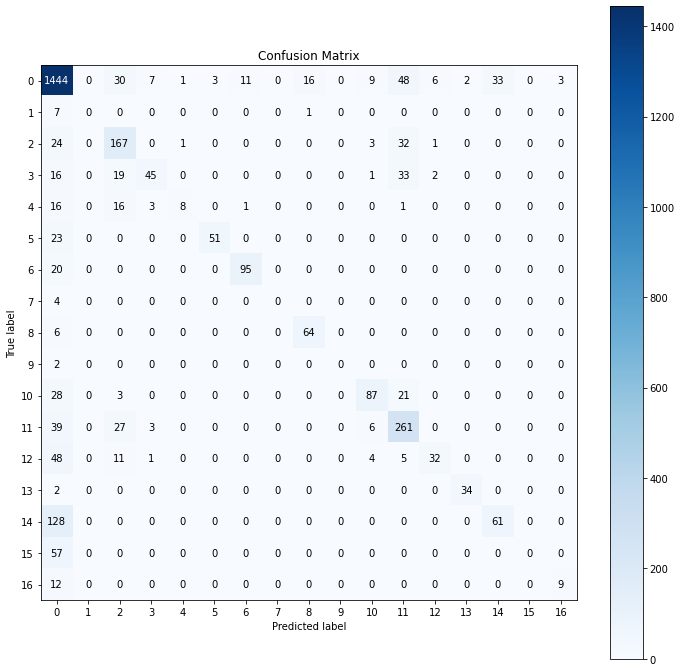

In [ ]:

! pip install -q scikit-plot

import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(
    y_test, 
    y_pred,
    figsize=(12,12));

In [ ]:
# print(confusion_matrix(y_test,y_pred))
print('Classification report:\n',classification_report(y_test,y_pred))

Classification report:
               precision    recall  f1-score   support

           0       0.77      0.90      0.83      1613
           1       0.00      0.00      0.00         8
           2       0.61      0.73      0.67       228
           3       0.76      0.39      0.51       116
           4       0.80      0.18      0.29        45
           5       0.94      0.69      0.80        74
           6       0.89      0.83      0.86       115
           7       0.00      0.00      0.00         4
           8       0.79      0.91      0.85        70
           9       0.00      0.00      0.00         2
          10       0.79      0.63      0.70       139
          11       0.65      0.78      0.71       336
          12       0.78      0.32      0.45       101
          13       0.94      0.94      0.94        36
          14       0.65      0.32      0.43       189
          15       0.00      0.00      0.00        57
          16       0.75      0.43      0.55        21

  

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



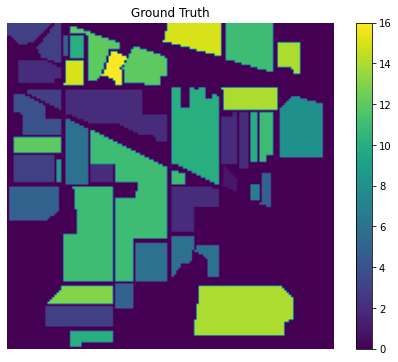

In [ ]:

plt.figure(figsize=(8, 6))
plt.imshow(df.iloc[:, -1].values.reshape((145, 145)))
plt.colorbar()
plt.axis('off')
plt.title('Ground Truth')
plt.savefig('ground_truth.png')
plt.show()

In [ ]:
# !pip install tqdm
from tqdm import tqdm
pre = y_pred

clmap = [0]*X.shape[0]

for i in tqdm(range(len(indices_train))):
    clmap[indices_train[i]] = y[indices_train[i]]

for i in tqdm(range(len(indices_test))):
    clmap[indices_test[i]] = pre[i]

100%|██████████| 3154/3154 [00:00<00:00, 584751.57it/s]


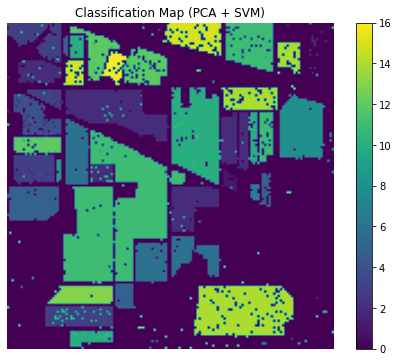

In [ ]:
plt.figure(figsize=(8, 6))
plt.imshow(np.array(clmap).reshape((145, 145)))
plt.colorbar()
plt.axis('off')
plt.title('Classification Map (PCA + SVM)')
plt.savefig('Classification_map.png')
plt.show()

In [4]:
# x=np.where([True, False,True, True])[0]
# x
aa_milne_arr = ['pooh', 'rabbit', 'piglet', 'Christopher']
np.random.choice(aa_milne_arr, 4, replace=False)

array(['pooh', 'Christopher', 'piglet', 'rabbit'], dtype='<U11')

In [54]:
#new pactice

from sklearn.decomposition import PCA
import numpy as np

def generate_hsi_cube(x_train, y_train, M, s):
    # Dimensionality reduction using PCA
    pca = PCA(n_components=200)
    x_train_pca = pca.fit_transform(x_train)

    # Reshape the data into a 3D array
    # n_pixels = x_train_pca.shape[0]
    # n_bands = x_train_pca.shape[1]

    n_pixels = x_train.shape[0]
    n_bands = x_train.shape[1]
    cube_shape = (s, s, n_bands)
    hsi_cube = np.zeros(cube_shape)
    gt_map = np.zeros((s, s))

    # Randomly select M_c land-cover categories
    M_c = np.random.randint(2, M)
    class_labels = np.unique(y_train)
    selected_labels = np.random.choice(class_labels[1:], M_c, replace=False)

    # Generate the HSI cube
    print()
    pixel_indices = np.where(np.isin(y_train, selected_labels))[0]  #get index
    selected_pixels = np.random.choice(pixel_indices, s**2, replace=False)
    for i, idx in enumerate(selected_pixels):
        x = x_train_pca[idx, :]
        # x = x_train[idx, :]
        row = i // s
        col = i % s
        hsi_cube[row, col, :] = x
        # gt_map[row, col] = selected_labels.index(y_train[idx])
        gt_map[row, col] = np.where(selected_labels == y_train[idx])[0][0]

    return hsi_cube, gt_map

In [10]:
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 KB 5.1 MB/s eta 0:00:00


In [ ]:
def generate_hsi_cube(x_train, y_train, M, s):
    # Reshape the data into a 3D array
    n_pixels = x_train.shape[0]
    n_bands = x_train.shape[1]
    cube_shape = (s, s, n_bands)
    hsi_cube = np.zeros(cube_shape)
    gt_map = np.zeros((s, s))

    # Randomly select M_c land-cover categories
    M_c = np.random.randint(1, M)
    class_labels = np.unique(y_train)
    selected_labels = np.random.choice(class_labels[1:], M_c, replace=False)

    # Generate the HSI cube
    for i, label in enumerate(selected_labels):
        pixel_indices = np.where(y_train == label)[0]
        selected_pixels = np.random.choice(pixel_indices, s**2, replace=True)
        for j, idx in enumerate(selected_pixels):
            x = x_train[idx, :]
            row = j // s
            col = j % s
            hsi_cube[row, col, :] = x
            gt_map[row, col] = i

    return hsi_cube, gt_map

In [84]:
# v2
import numpy as np
from scipy.spatial.distance import cdist

def generate_hsi_cube(x_train, y_train, M, s):
    # Reshape the data into a 3D array
    n_pixels = x_train.shape[0]
    n_bands = x_train.shape[1]
    cube_shape = (s, s, n_bands)
    hsi_cube = np.zeros(cube_shape)
    gt_map = np.zeros((s, s))

    # Randomly select M_c land-cover categories
    M_c = np.random.randint(2, M)
    class_labels = np.unique(y_train)
    selected_labels = np.random.choice(class_labels[1:], M_c, replace=False)

    # Generate the HSI cube
    pixel_indices = [np.where(y_train == label)[0] for label in selected_labels]
    n_pixels_label = [min(s**2 // M_c, len(p)) for p in pixel_indices]

    for i, indices in enumerate(pixel_indices):
        if len(indices) < n_pixels_label[i]:
            # Generate virtual samples using the formula Aij = exp(−||xi − xj ||^2 /2 )
            n_virtual_samples = n_pixels_label[i] - len(indices)
            if n_virtual_samples > len(indices):
                raise ValueError("Not enough samples in selected label to generate virtual samples")
            distances = cdist(x_train[indices], x_train[indices], metric='euclidean')
            Aij = np.exp(-1 * (distances ** 2) / 2)
            for j in range(n_virtual_samples):
                j_idx = np.random.randint(len(indices))
                mix = np.dot(Aij[j_idx, :], x_train[indices]) / np.sum(Aij[j_idx, :])
                x_virtual = mix + np.random.normal(scale=0.1, size=n_bands)
                x_train = np.vstack((x_train, x_virtual))
                indices = np.append(indices, n_pixels + j)
        
        selected_pixels = np.random.choice(indices, n_pixels_label[i], replace=False)
        for j, idx in enumerate(selected_pixels):
            x = x_train[idx, :]
            row = (i * n_pixels_label[i] + j) // s
            col = (i * n_pixels_label[i] + j) % s
            hsi_cube[row, col, :] = x
            gt_map[row, col] = i

    return hsi_cube, gt_map

In [15]:
import numpy as np
from scipy.spatial.distance import cdist

def generate_hsi_cube(x_train, y_train, M, s):
    # Reshape the data into a 3D array
    n_pixels = x_train.shape[0]
    n_bands = x_train.shape[1]
    cube_shape = (s, s, n_bands)
    hsi_cube = np.zeros(cube_shape)
    gt_map = np.zeros((s, s))

    # Randomly select M_c land-cover categories
    M_c = np.random.randint(1, M)
    class_labels = np.unique(y_train)
    selected_labels = np.random.choice(class_labels[1:], M_c, replace=False)

    # Generate the HSI cube
    selected_pixels = []
    vs=[]
    vs_gt = []
    n_vs_px_g = 0
    for i, label in enumerate(selected_labels):
        pixel_indices = np.where(y_train == label)[0]
        n_pixels_label = np.random.randint(1, s**2 + 1 - sum([len(p) for p in selected_pixels]) - (M_c - i - 1 )-n_vs_px_g)
        vs_px = 0
        if(len(pixel_indices) < n_pixels_label):
            print("red")
            vs_px = len(pixel_indices) - n_pixels_label
            for k in range(vs_px):
                vs_px_idx=np.random.choice(pixel_indices, 1, replace=False)
                vs_px_jdx=np.random.choice(pixel_indices, 1, replace=False)
                distances = cdist(x_train[vs_px_idx], x_train[vs_px_jdx], metric='euclidean')
                Aij = np.exp(-1 * (distances ** 2) / 2)
                mix = (1-Aij)*x_train[vs_px_idx]+Aij*x_train[vs_px_jdx]
                vs.append(mix)
                vs_gt.append(label)
                n_vs_px_g+=vs_px

        pixels = np.random.choice(pixel_indices, n_pixels_label-vs_px, replace=False)
        selected_pixels.append(pixels)

    selected_pixels = np.concatenate(selected_pixels)
    np.random.shuffle(selected_pixels)

    for i, idx in enumerate(selected_pixels):
        x = x_train[idx, :]
        row = i // s
        col = i % s
        hsi_cube[row, col, :] = x
        gt_map[row, col] = np.where(selected_labels == y_train[idx])[0][0]

    for i, idx in enumerate(vs):
        # x = x_train[idx, :]
        row = (i + len(selected_pixels)) // s
        col = (i + len(selected_pixels))% s
        hsi_cube[row, col, :] = idx
        gt_map[row, col] = vs_gt[0]

    return hsi_cube, gt_map

(16820, 200)
[[ 0.  0.  2.  0.  1.  1.  0.  0.  0.  4.  3.]
 [ 3.  0.  0.  1.  3.  1.  0.  0.  1.  0. 12.]
 [ 0.  0.  1.  0.  0.  3.  0.  3.  1.  0.  8.]
 [ 6.  2.  0.  2.  0.  3.  0.  1.  2.  3.  1.]
 [ 0.  1.  2.  0.  3. 11.  0.  1.  0.  1.  0.]
 [ 1.  1.  7. 14.  3.  1.  2.  3.  3.  0.  5.]
 [ 0. 10.  1.  0.  0.  3.  0.  3.  1.  1.  1.]
 [ 9.  0.  2.  1.  0.  2.  0.  2.  0.  0.  1.]
 [ 2.  1.  1.  0.  1.  0.  1.  0.  2.  0.  1.]
 [ 3.  2.  0.  0.  1.  1.  2.  3.  1.  1.  1.]
 [ 2.  1.  3.  3.  0.  2.  2.  1.  0.  0. 13.]]


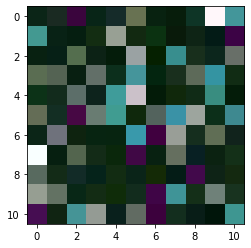

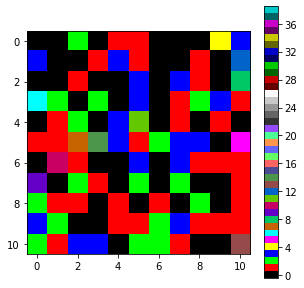

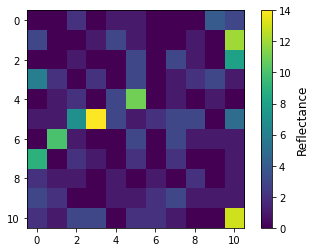

In [20]:


from sklearn.datasets import fetch_openml
import numpy as np
import spectral
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Import the Indian Pines dataset
indian_pines = fetch_openml(name='Indian_pines')

# Get the data and corresponding labels
# X = indian_pines.data
# y = indian_pines.target

# X = dataset.ravel()
# y = ground_truth.ravel()

# Preprocess the data
# X = X.astype(float)
# X /= np.max(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

# Encode the class labels
# le = LabelEncoder()
# y_train = le.fit_transform(y_train)
# y_test = le.transform(y_test)

print(X_train.shape)




# Apply the generate_hsi_cube function with s=5
hsi_cube, gt_map = generate_hsi_cube(X_train, y_train, M=16, s=11)

# Display the HSI cube and ground-truth map using spectral library
spectral.imshow(hsi_cube, (29, 19, 9))
spectral.imshow(classes=gt_map.astype(int), figsize=(5, 5))
plt.colorbar()

# Display HSI cube with colorbar
fig, ax = plt.subplots()
im = ax.imshow(gt_map)
cbar = plt.colorbar(im)
cbar.ax.set_ylabel('Reflectance', fontsize=12)

print(gt_map)

In [21]:
df = extract_pixels(hsi_cube, gt_map)

df.head()



100%|██████████| 200/200 [00:00<00:00, 845.17it/s] 


,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,...,band-192,band-193,band-194,band-195,band-196,band-197,band-198,band-199,band-200,class
0,2730.0,4010.0,3964.0,3818.0,4212.0,4283.0,4281.0,4252.0,4022.0,3833.0,...,1016.0,1021.0,1016.0,1017.0,1010.0,1006.0,1012.0,1014.0,1005.0,0.0
1,2983.0,4126.0,4226.0,3894.0,4212.0,4376.0,4377.0,4257.0,4124.0,3895.0,...,1025.0,1016.0,1019.0,1019.0,1003.0,1017.0,1008.0,1001.0,1001.0,0.0
2,2602.0,3869.0,4131.0,4123.0,4243.0,4565.0,4516.0,4353.0,4312.0,4065.0,...,1034.0,1039.0,1049.0,1029.0,1029.0,1021.0,1017.0,1018.0,996.0,2.0
3,3148.0,3981.0,4105.0,3957.0,4209.0,4370.0,4409.0,4252.0,4085.0,3832.0,...,1013.0,1019.0,1013.0,1007.0,1011.0,1001.0,1007.0,997.0,1000.0,0.0
4,3010.0,3864.0,4028.0,3951.0,4101.0,4268.0,4278.0,4213.0,4162.0,3939.0,...,1021.0,1018.0,1020.0,1011.0,1014.0,1006.0,1003.0,999.0,1004.0,1.0


In [22]:
df

,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,...,band-192,band-193,band-194,band-195,band-196,band-197,band-198,band-199,band-200,class
0,2730.0,4010.0,3964.0,3818.0,4212.0,4283.0,4281.0,4252.0,4022.0,3833.0,...,1016.0,1021.0,1016.0,1017.0,1010.0,1006.0,1012.0,1014.0,1005.0,0.0
1,2983.0,4126.0,4226.0,3894.0,4212.0,4376.0,4377.0,4257.0,4124.0,3895.0,...,1025.0,1016.0,1019.0,1019.0,1003.0,1017.0,1008.0,1001.0,1001.0,0.0
2,2602.0,3869.0,4131.0,4123.0,4243.0,4565.0,4516.0,4353.0,4312.0,4065.0,...,1034.0,1039.0,1049.0,1029.0,1029.0,1021.0,1017.0,1018.0,996.0,2.0
3,3148.0,3981.0,4105.0,3957.0,4209.0,4370.0,4409.0,4252.0,4085.0,3832.0,...,1013.0,1019.0,1013.0,1007.0,1011.0,1001.0,1007.0,997.0,1000.0,0.0
4,3010.0,3864.0,4028.0,3951.0,4101.0,4268.0,4278.0,4213.0,4162.0,3939.0,...,1021.0,1018.0,1020.0,1011.0,1014.0,1006.0,1003.0,999.0,1004.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
116,3026.0,3987.0,3938.0,4031.0,4291.0,4495.0,4490.0,4381.0,4337.0,4062.0,...,1031.0,1033.0,1034.0,1035.0,1016.0,1020.0,1022.0,996.0,1004.0,2.0
117,3193.0,3740.0,4024.0,3805.0,4095.0,4328.0,4360.0,4135.0,3988.0,3870.0,...,1020.0,1007.0,1016.0,1011.0,1009.0,1005.0,1011.0,1017.0,995.0,1.0
118,2999.0,3874.0,4051.0,3882.0,4046.0,4424.0,4376.0,4060.0,4053.0,3829.0,...,1021.0,1016.0,1018.0,1008.0,1014.0,1014.0,1002.0,1006.0,1010.0,0.0
119,3143.0,3847.0,4013.0,3878.0,4034.0,4214.0,4180.0,4042.0,4032.0,3751.0,...,1006.0,1007.0,1017.0,1013.0,1009.0,1014.0,1007.0,1008.0,1009.0,0.0


In [23]:
df=df.sort_values(by=['class'])
df

,band-1,band-2,band-3,band-4,band-5,band-6,band-7,band-8,band-9,band-10,...,band-192,band-193,band-194,band-195,band-196,band-197,band-198,band-199,band-200,class
0,2730.0,4010.0,3964.0,3818.0,4212.0,4283.0,4281.0,4252.0,4022.0,3833.0,...,1016.0,1021.0,1016.0,1017.0,1010.0,1006.0,1012.0,1014.0,1005.0,0.0
28,3152.0,3850.0,4020.0,3814.0,4089.0,4371.0,4312.0,4130.0,4106.0,3686.0,...,1011.0,1015.0,1016.0,1010.0,1006.0,1006.0,1007.0,1004.0,1005.0,0.0
95,2997.0,3747.0,4126.0,3882.0,4022.0,4271.0,4362.0,4167.0,4052.0,3822.0,...,1018.0,1016.0,1020.0,1012.0,1014.0,1010.0,1011.0,1001.0,1004.0,0.0
119,3143.0,3847.0,4013.0,3878.0,4034.0,4214.0,4180.0,4042.0,4032.0,3751.0,...,1006.0,1007.0,1017.0,1013.0,1009.0,1014.0,1007.0,1008.0,1009.0,0.0
31,2727.0,4106.0,4103.0,3956.0,4141.0,4471.0,4418.0,4246.0,4121.0,3860.0,...,1028.0,1019.0,1017.0,1003.0,1016.0,1010.0,1008.0,1010.0,1009.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,3663.0,4383.0,4321.0,4340.0,4472.0,4872.0,4812.0,4679.0,4669.0,4450.0,...,1082.0,1074.0,1089.0,1066.0,1059.0,1066.0,1045.0,1025.0,1015.0,10.0
49,2589.0,4253.0,4505.0,4414.0,4766.0,5141.0,5161.0,5168.0,5040.0,4920.0,...,1102.0,1102.0,1105.0,1095.0,1069.0,1076.0,1044.0,1024.0,1009.0,11.0
21,3002.0,4100.0,4031.0,4027.0,4271.0,4420.0,4551.0,4374.0,4353.0,4112.0,...,1041.0,1041.0,1038.0,1026.0,1024.0,1028.0,1021.0,1013.0,1008.0,12.0
120,2607.0,3995.0,4302.0,4112.0,4519.0,4808.0,4859.0,4763.0,4761.0,4581.0,...,1068.0,1064.0,1070.0,1051.0,1041.0,1035.0,1031.0,1029.0,1004.0,13.0


Text(0, 0.5, 'Reflectance')

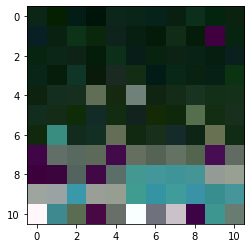

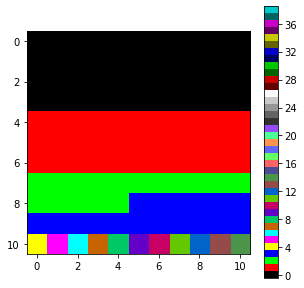

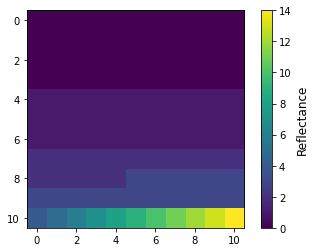

In [25]:
arng_cube = df.iloc[:, :-1].values

arng_gt_map = df.iloc[:, -1].values

arng_cube=np.reshape(arng_cube, (11, 11,200))
arng_gt_map=np.reshape(arng_gt_map, (11, 11))

# Display the HSI cube and ground-truth map using spectral library
spectral.imshow(arng_cube, (29, 19, 9))
spectral.imshow(classes=arng_gt_map.astype(int), figsize=(5, 5))
plt.colorbar()

# Display HSI cube with colorbar
fig, ax = plt.subplots()
im = ax.imshow(arng_gt_map)
cbar = plt.colorbar(im)
cbar.ax.set_ylabel('Reflectance', fontsize=12)

In [ ]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import spectral

def generate_training_pixels(data, labels, M_c):
    # Get indices of pixels corresponding to each label
    label_indices = {}
    for i in range(labels.shape[0]):
        for j in range(labels.shape[1]):
            label = labels[i, j]
            if label not in label_indices:
                label_indices[label] = []
            label_indices[label].append((i, j))

    # Select M_c labels at random
    selected_labels = np.random.choice(list(label_indices.keys()), size=M_c, replace=False)

    # Select pixels corresponding to selected labels
    selected_pixels = []
    for label in selected_labels:
        selected_pixels += label_indices[label]

    return selected_pixels, selected_labels


def apply_pca(data, selected_pixels):
    # Select pixels from data
    x_train = data.reshape(-1, data.shape[-1])[selected_pixels]

    # Apply PCA
    pca = PCA(n_components=220)
    x_train_pca = pca.fit_transform(x_train)

    return x_train_pca


def generate_hsi_cube(x_train_pca, selected_pixels, selected_labels, s):
    # Initialize HSI cube and ground-truth map
    hsi_cube = np.zeros((s, s, x_train_pca.shape[1]))
    gt_map = np.zeros((s, s))

    # Select s^2 random pixels from selected pixels
    np.random.shuffle(selected_pixels)
    selected_pixels = selected_pixels[:s*s]

    # Fill in HSI cube and ground-truth map
    for i, idx in enumerate(selected_pixels):
        x = x_train_pca[idx, :]
        row = i // s
        col = i % s
        hsi_cube[row, col, :] = x
        label_idx = np.where(selected_labels == y_train[idx])[0]
        gt_map[row, col] = label_idx

    return hsi_cube, gt_map


# Load Indian Pines dataset
data_path = 'Indian_pines_corrected.mat'
label_path = 'Indian_pines_gt.mat'

data = sio.loadmat(data_path)['indian_pines_corrected']
labels = sio.loadmat(label_path)['indian_pines_gt']

# Apply HSI cube generation algorithm
s = 5
M = np.max(labels)
M_c = np.random.randint(1, M)

selected_pixels, selected_labels = generate_training_pixels(data, labels, M_c)
x_train_pca = apply_pca(data, selected_pixels)
hsi_cube, gt_map = generate_hsi_cube(x_train_pca, selected_pixels, selected_labels, s)

# Display HSI cube with colorbar
fig, ax = plt.subplots()
im = ax.imshow(hsi_cube)
cbar = plt.colorbar(im)
cbar.ax.set_ylabel('Reflectance', fontsize=12)

# Display ground-truth map with colors
color_map = spectral.spy_colors
spectral.imshow(gt_map, color_map=color_map)

plt.show()

ValueError: ignored